# What does an customer default with Afterpay look like ?
> Let's take a high level view of what an aveage default looks like, based on Afterpay's FY2019 Annual report.

- toc: true 
- badges: true
- comments: true
- categories: [Bayesian,PyMC3,Finance,Monte Carlo Simulation,Afterpay]
    
- image: images/2020-08-22-Afterpay-Customer-Defaults-Part-3/header.png

# POST IN PROGRESS

## Introduction

From the [previous post]()


> Important:  Obviously I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.




## Robustness Study

We now have ability to compute the expected average late fee, given a distribution of transaction values, and a probability of making payment on time.

Given this, we can try lots of different distributions, and use this to find the distribution of average late fees that we could see.




In [9]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import scipy.stats as st

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

## Improving performance

### Direct Model

As part of our simulation, we need to know the distribution of late fees, for any given probability of late payment.

We can directly model this in PyMC3, and it takes 3 seconds to generate 100,000 samples.

In [10]:
def create_late_fee_distribution(late_payment_probability, num_samples=100_000):
    with pm.Model() as fee_model:
        number_of_delays_of_less_than_1_week = 1 + pm.Binomial('number_of_delays_of_less_than_1_week', n=3, p=late_payment_probability)
        number_of_delays_of_more_than_1_week = pm.Binomial('number_of_delays_of_more_than_1_week', n=number_of_delays_of_less_than_1_week, p=late_payment_probability)
        total_fees = pm.Deterministic('total_fees',10 * number_of_delays_of_less_than_1_week + 7 * number_of_delays_of_more_than_1_week)

        samples = pm.sample_prior_predictive(samples = num_samples, random_seed=0)
    return(samples)

Now let's visualise the distribution we would see, if a customer has a 50% chance of defaulting on any given payment.

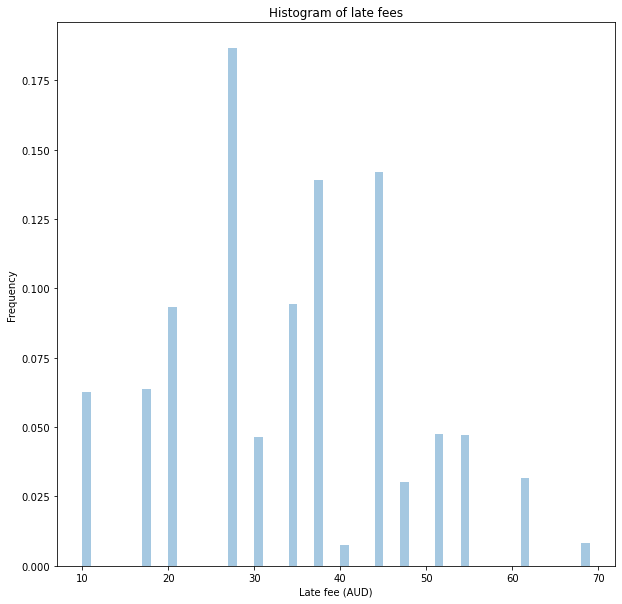

In [11]:
samples = create_late_fee_distribution(late_payment_probability = 0.5)

sns.distplot(samples["total_fees"],kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.title('Histogram of late fees')
plt.ylabel('Frequency')
plt.xlabel('Late fee (AUD)')
plt.show()

### Categorical Model

One solution to enable us to sample faster, is to capture the output from the direct model, which precisely models the underlying process, and to create a surrogate model. This model uses a categorical distribution to efficently generate samples with the same distribution.

Using this surrogate model, we can generate 100,000 samples in only 60ms, a 50 fold speedup.

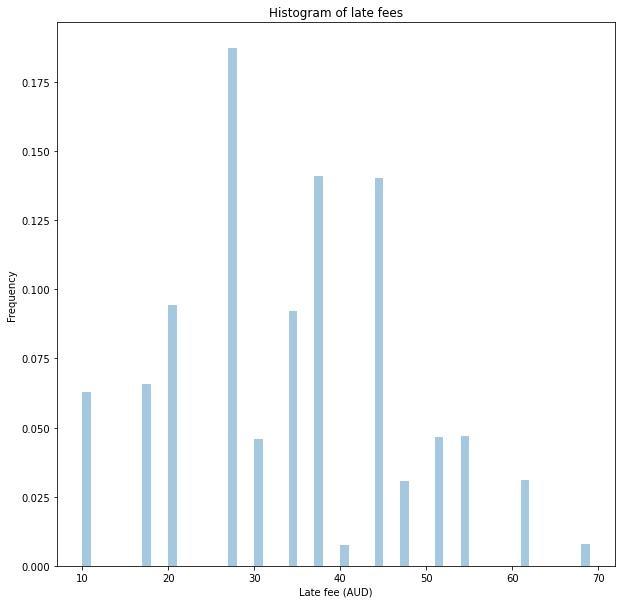

In [12]:
def create_late_fee_surrogate_distribution(late_fee_samples):
    unique, counts = np.unique(late_fee_samples, return_counts=True) 
    
    categorical_map = {}
    for i in range(len(unique)):
        categorical_map[i] = unique[i]
    
    with pm.Model() as categorical_fee_model:
        late_fee_distribution_categorical = pm.Categorical('late_fee_distribution_categorical',counts)
    
    return(categorical_fee_model, categorical_map)

def generate_samples(categorical_fee_model, categorical_map):
    with categorical_fee_model:
        samples = pm.sample_prior_predictive(samples=100_000)

    late_fee_samples = np.zeros_like(samples["late_fee_distribution_categorical"])

    for i in range(len(categorical_map.keys())):
        late_fee_samples[samples["late_fee_distribution_categorical"] == i] = categorical_map[i]

    return(late_fee_samples)

categorical_fee_model, categorical_map = create_late_fee_surrogate_distribution(samples["total_fees"])

late_fee_samples = generate_samples(categorical_fee_model, categorical_map)

plt.title('Histogram of late fees')
plt.ylabel('Relative Frequency')
plt.xlabel('Late fee (AUD)')
sns.distplot(late_fee_samples,kde=False, norm_hist=True, bins=np.arange(10,70,1))
plt.show()

### Transaction value model

As in the last post, we can model the transaction values has being exponentially distributed. I'm also applying an upper bound at 1,500 AUD, which is the limit for a transaction using *Afterpay*.


## Grid Evaluation

Now we can find the average late fee under a range of different combinations of both late payment probability, and average transaction size.

First off, let's create a dictionary of categorical models, so we can quickly draw new samples.

In [13]:
fee_models = {}
for late_payment_probability_percent in range(0, 101,5):
    samples = create_late_fee_distribution(late_payment_probability = late_payment_probability_percent/100.0) 
    fee_models[late_payment_probability_percent] = create_late_fee_surrogate_distribution(samples["total_fees"])

Now it's time to generate the grid.

In [14]:
def perform_parametric_study(transaction_value_sampling_function):
    grid = np.zeros((21,20))
    for average_transaction_value_aud in range(50,250,10):

        transaction_value_samples = transaction_value_sampling_function(average_transaction_value_aud)
        for late_payment_probability_percent in range(0, 101,5):
            categorical_fee_model, categorical_map = fee_models[late_payment_probability_percent]

            #Draw a distribution of late fees
            late_fee_samples = generate_samples(categorical_fee_model,categorical_map)

            #Limit the late fees to be at at most 25% of the transaction value
            late_fees = np.minimum(late_fee_samples, 0.25*transaction_value_samples)
            #And at least $10 AUD
            late_fees = np.maximum(late_fees,10)

            mean_late_fee = np.mean(late_fees)

            grid[int(late_payment_probability_percent/5), int((average_transaction_value_aud-50)/10)] = mean_late_fee
            
    return(grid)


In [15]:
def visualise_grid(grid,title):
    x_axis_labels = range(50,250,10) 
    y_axis_labels = range(0, 101,5)

    sns.heatmap(grid,xticklabels=x_axis_labels, yticklabels=y_axis_labels,cbar_kws={'label': 'Average late fee (AUD)'},annot=True)
    plt.xlabel('Average Transaction Value (AUD)')
    plt.ylabel('Probability of late payment on any transaction (%)')
    plt.title(title)
    plt.show()

## Exponential distribution

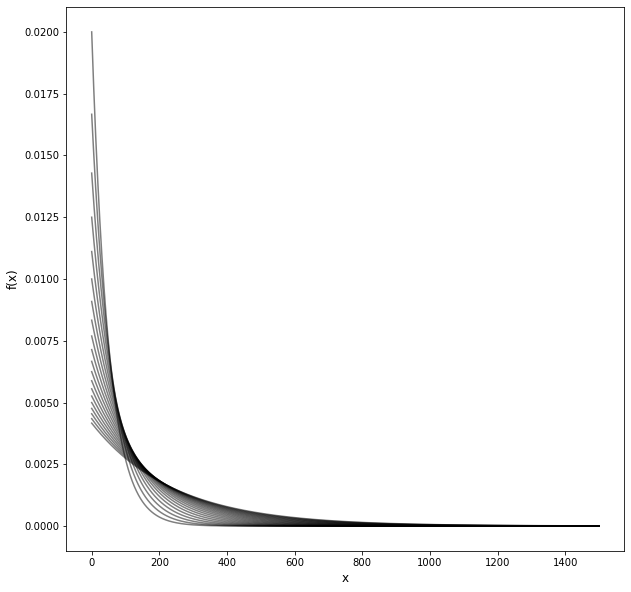

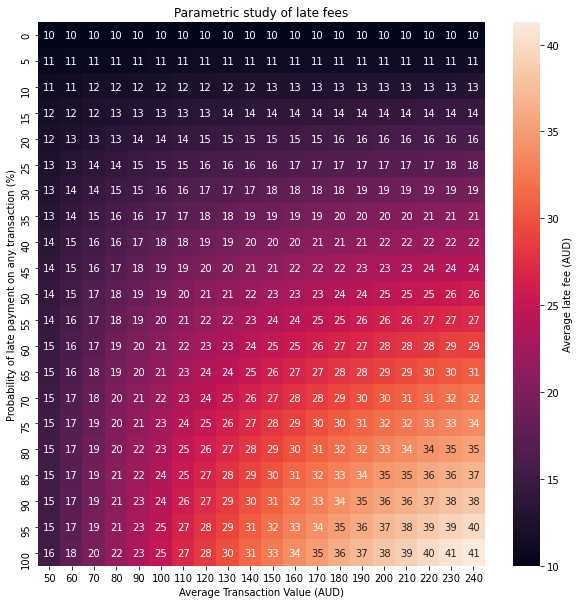

In [16]:
x = np.linspace(0, 1500,1500)
for average_transaction_value_aud in range(50,250,10):
    pdf = st.expon.pdf(x, scale = average_transaction_value_aud )
    plt.plot(x, pdf,color='k',alpha=0.5)
plt.xlabel('Transaction Value (AUD)
plt.ylabel('Relative Frequency')
plt.show()


def create_exponential_transaction_value_samples(average_transaction_value_aud):
    with pm.Model() as transaction_value_model:
        transaction_value_aud = pm.Bound(pm.Exponential, upper=1_500.0)('transaction_value_aud', lam = 1/average_transaction_value_aud)
        transaction_value_samples = pm.sample_prior_predictive(samples=100_000)
        transaction_value_samples = transaction_value_samples['transaction_value_aud']
    return(transaction_value_samples)    

exponential_grid = perform_parametric_study(create_exponential_transaction_value_samples)
visualise_grid(exponential_grid,'Parametric study of late fees')

## Half Normal Distribution

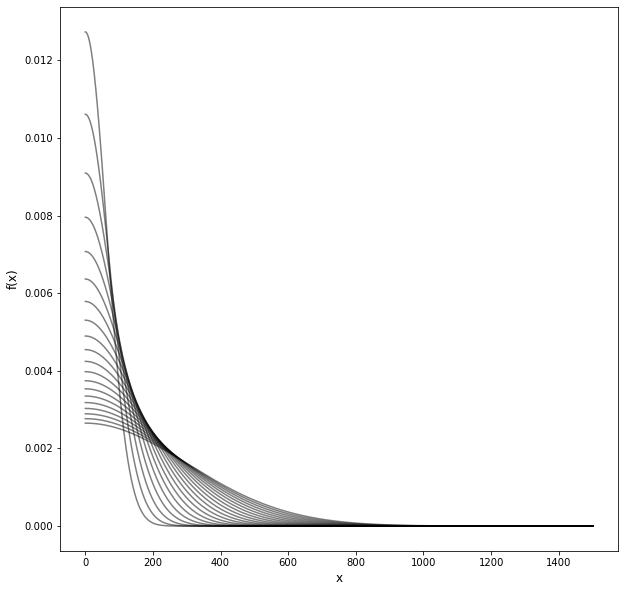

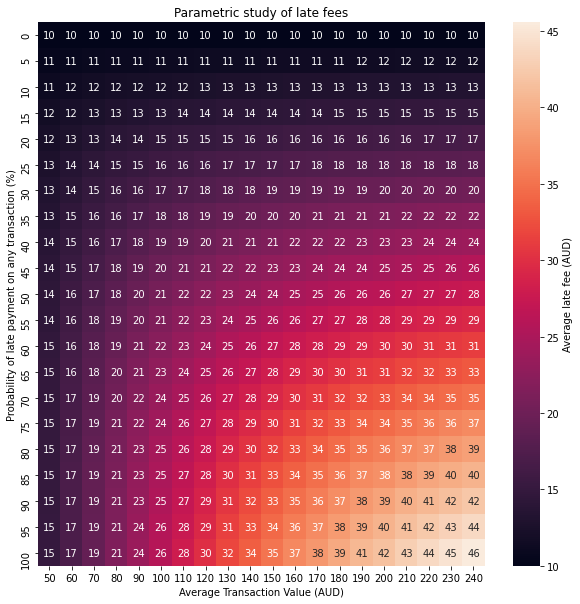

In [17]:
x = np.linspace(0, 1500,1500)
for average_transaction_value_aud in range(50,250,10):
    sigma = average_transaction_value_aud * np.sqrt(np.pi) /  np.sqrt(2)  
    pdf = st.halfnorm.pdf(x, scale=sigma)
    plt.plot(x, pdf,color='k',alpha=0.5)
plt.xlabel('Transaction Value (AUD)
plt.ylabel('Relative Frequency')
plt.show()



def create_halfnormal_transaction_value_samples(average_transaction_value_aud):
    sigma = average_transaction_value_aud * np.sqrt(np.pi) /  np.sqrt(2)     
    with pm.Model() as transaction_value_model:
        transaction_value_aud = pm.Bound(pm.HalfNormal,lower=0, upper=1_500.0)('transaction_value_aud', sigma = sigma)
        transaction_value_samples = pm.sample_prior_predictive(samples = 100_000)
        transaction_value_samples = transaction_value_samples['transaction_value_aud']
    return(transaction_value_samples)    


halfnormal_grid = perform_parametric_study(create_halfnormal_transaction_value_samples)
visualise_grid(halfnormal_grid,'Parametric study of late fees')

## Conclusion

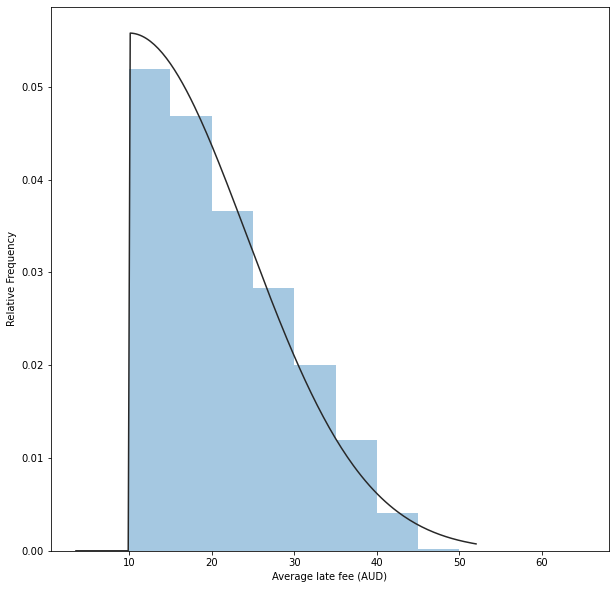

In [49]:
late_fee_distribution = np.stack([halfnormal_grid, exponential_grid]).ravel()

offset, std = st.halfnorm.fit(late_fee_distribution)

sns.distplot(late_fee_distribution,fit=st.halfnorm,  kde=False, bins = np.arange(10,68,5))
plt.ylabel('Relative Frequency')
plt.xlabel('Average late fee (AUD)')
plt.show()